In [1]:
cd ..

c:\Users\Tanner\Documents\repos\ironmarch-archetypal


In [10]:
import torch
import numpy as np
from models import VAE, InterpolatedLinearLayers
import seaborn

In [4]:
import json
import os

In [12]:
BERT_embedding_size = 768
def _get_model(config, device):
        if config['dataset']['context']:
            input_dim = BERT_embedding_size * 2
        else:
            input_dim = BERT_embedding_size
        encoder = InterpolatedLinearLayers(
            input_size = input_dim, 
            output_size = config['model']['latent_dims'] * 2, 
            num_layers = config['model']['encoder']['depth'], 
            bias = config['model']['encoder']['bias']
        )
        decoder = InterpolatedLinearLayers(
            config['model']['latent_dims'], 
            input_dim, 
            num_layers = config['model']['decoder']['depth'], 
            bias = config['model']['decoder']['bias']
        )
        feature_head = torch.nn.Linear(config['model']['latent_dims'], 7)
        model = VAE(
            encoder = encoder,
            decoder = decoder,
            feature_head = feature_head,
            use_softmax = config['model']['softmax']
        )
        model.to(device)
        return model

In [6]:
model_path = 'results\\train_sinkhorn_vae_2021-08-12_19-45-38\\train_sinkhorn_vae_c774e2cc_6_one=0.94555,zero=0.8_2021-08-12_19-45-38'
checkpoint_path = 'results\\train_sinkhorn_vae_2021-08-12_19-45-38\\train_sinkhorn_vae_c774e2cc_6_one=0.94555,zero=0.8_2021-08-12_19-45-38\checkpoint_000040'

In [7]:
with open(os.path.join(model_path, 'params.json')) as params_file:
    config = json.loads(params_file.read())

In [17]:
model = _get_model(config, 'cpu')
model_state_dictionary, _ = torch.load(os.path.join(checkpoint_path, 'checkpoint'))
model.load_state_dict(model_state_dictionary)
transformation_matrix = model.feature_head.weight.data

In [18]:
vector_lengths = torch.pow(torch.sum(torch.pow(transformation_matrix, 2), dim = 1), 1/2)
normalized_plane_vectors = torch.div(transformation_matrix.T, vector_lengths).T

In [19]:
feature_names = [
    'nationality_hate',
    'ethnicity_hate',
    'religion_hate',
    'gender_hate',
    'sexual_orientation_hate',
    'disability_hate',
    'class_hate'
]

In [20]:
for name, plane_vector in zip(feature_names, normalized_plane_vectors.numpy()):
    print(name + ' : \n' + str(np.around(plane_vector, decimals = 2)))

nationality_hate : 
[-0.06 -0.13  0.21  0.02  0.08 -0.45 -0.08 -0.2   0.25 -0.09 -0.48 -0.26
 -0.36  0.37  0.21  0.09]
ethnicity_hate : 
[-0.03 -0.06  0.31  0.05  0.16 -0.4   0.04 -0.24  0.1  -0.07 -0.53 -0.28
 -0.29  0.35  0.24  0.07]
religion_hate : 
[-0.09 -0.23  0.34  0.04  0.06 -0.36 -0.11 -0.25  0.1  -0.15 -0.45 -0.32
 -0.35  0.27  0.27  0.08]
gender_hate : 
[-0.08  0.35 -0.04  0.21  0.3  -0.36 -0.18 -0.18 -0.31 -0.22 -0.44 -0.23
 -0.3   0.21  0.12 -0.02]
sexual_orientation_hate : 
[ 0.04  0.28 -0.    0.24  0.3  -0.36 -0.25 -0.19 -0.27 -0.18 -0.45 -0.32
 -0.28  0.17  0.11  0.14]
disability_hate : 
[ 0.15  0.23  0.07  0.01  0.25 -0.37 -0.31 -0.19 -0.28 -0.28 -0.45 -0.19
 -0.26  0.23  0.09  0.26]
class_hate : 
[-0.2  -0.11 -0.03  0.09  0.24 -0.42  0.38 -0.26 -0.26 -0.25 -0.37 -0.24
 -0.32  0.26 -0.06 -0.04]


<AxesSubplot:>

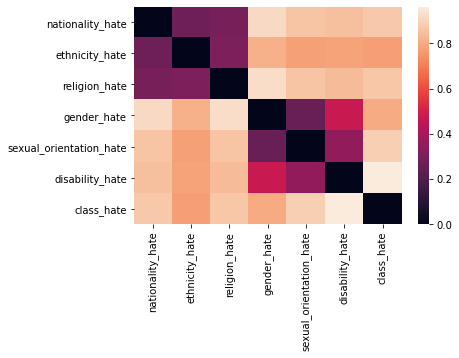

In [21]:
def get_cos_sim(vec_one, vec_two):
    result = torch.acos(torch.dot(vec_one, vec_two))
    if torch.equal(result, torch.tensor(1.0)):
        return torch.tensor(0.0)
    if result.isnan():
        return torch.tensor(0.0)
    return result

similarity_heat_map = torch.zeros((normalized_plane_vectors.shape[0], normalized_plane_vectors.shape[0]))

for i in range(normalized_plane_vectors.shape[0]):
    for j in range(normalized_plane_vectors.shape[0]):
        similarity_heat_map[i, j] = get_cos_sim(normalized_plane_vectors[i], normalized_plane_vectors[j])

seaborn.heatmap(similarity_heat_map, xticklabels=feature_names, yticklabels=feature_names)